# Lotka-Volterra

How efficient are the solvers on a simple benchmark problem?

In [1]:
import functools

import jax
import jax.experimental.ode
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scipy.integrate
from diffeqzoo import backend, ivps
from jax import config

from probdiffeq import controls, solution_routines, solvers
from probdiffeq.doc_util import benchmark, info, notebook
from probdiffeq.implementations import recipes
from probdiffeq.strategies import filters

In [2]:
# x64 precision
config.update("jax_enable_x64", True)

# CPU
config.update("jax_platform_name", "cpu")

# IVP examples in JAX
if not backend.has_been_selected:
    backend.select("jax")

# Nice-looking plots
plt.rcParams.update(notebook.plot_config())

# Which version of the softwares are we using?
info.print_info()

probdiffeq version:
	0.1.1.dev7
Most recent commit:
	b'dd984c\n'

jax:    0.4.4
jaxlib: 0.4.4
numpy:  1.24.2
python: 3.10.6 (main, Nov 14 2022, 16:10:14) [GCC 11.3.0]
jax.devices (1 total, 1 local): [CpuDevice(id=0)]
process_count: 1


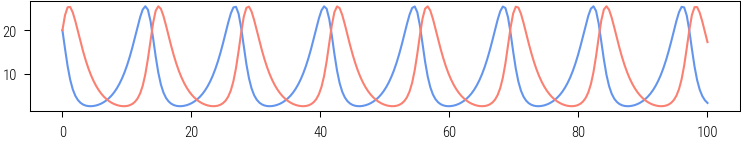

In [3]:
# Make a problem
f, u0, (t0, t1), f_args = ivps.lotka_volterra(time_span=(0.0, 100.0))
ODE_NAME = "Lotka-Volterra"


@jax.jit
def vf(x, *, t, p):
    return f(x, *p)


@jax.jit
def vf_jax(u, t, *p):
    return vf(u, t=t, p=p)


@jax.jit
def vf_scipy(t, u, *p):
    return vf(u, t=t, p=p)


vf_scipy_jac = jax.jit(jax.jacfwd(vf_scipy, argnums=1))

# Compile
vf(u0, t=t0, p=f_args)
vf_jax(u0, t0, *f_args)
vf_scipy(t0, u0, *f_args)
vf_scipy_jac(t0, u0, *f_args)

ts = jnp.linspace(t0, t1, num=250)
scipy_solution = scipy.integrate.solve_ivp(
    vf_scipy,
    y0=u0,
    t_span=(t0, t1),
    args=f_args,
    t_eval=ts,
    atol=2.23 * 1e-14,
    rtol=2.23 * 1e-14,
    method="LSODA",  # LSODA because it is not a competitor
    jac=vf_scipy_jac,
)
ys_reference = scipy_solution.y.T[-1, :]

fig, ax = plt.subplots(figsize=(5, 1))
ax.plot(ts, scipy_solution.y.T, marker="None")
plt.show()

In [4]:
def solver_to_solve(solver):
    return jax.jit(functools.partial(_solve, solver=solver))


def _solve(*, solver, tol):
    solution = solution_routines.simulate_terminal_values(
        vf,
        initial_values=(u0,),
        t0=t0,
        t1=t1,
        parameters=f_args,
        solver=solver,
        atol=1e-3 * tol,
        rtol=tol,
        control=controls.ProportionalIntegral(),
    )
    diff = (solution.u - ys_reference) / (1e-5 + ys_reference)
    return jnp.linalg.norm(diff) / jnp.sqrt(diff.size)


@functools.partial(jax.jit, static_argnames=("tol",))  # hm...
def jax_solve(*, tol):
    odeint_solution = jax.experimental.ode.odeint(
        vf_jax, u0, jnp.asarray([t0, t1]), *f_args, atol=1e-3 * tol, rtol=tol
    )
    diff = (odeint_solution[-1, :] - ys_reference) / (1e-5 + ys_reference)
    return jnp.linalg.norm(diff) / jnp.sqrt(diff.size)


def scipy_solve_ivp_rk45(*, tol):
    scipy_solution = scipy.integrate.solve_ivp(
        vf_scipy,
        y0=u0,
        t_span=(t0, t1),
        args=f_args,
        t_eval=jnp.asarray([t0, t1]),
        atol=1e-3 * tol,
        rtol=tol,
        method="RK45",
    )
    diff = (scipy_solution.y[:, -1] - ys_reference) / (1e-5 + ys_reference)
    return jnp.linalg.norm(diff) / jnp.sqrt(diff.size)


def scipy_solve_ivp_dop853(*, tol):
    scipy_solution = scipy.integrate.solve_ivp(
        vf_scipy,
        y0=u0,
        t_span=(t0, t1),
        args=f_args,
        t_eval=jnp.asarray([t0, t1]),
        atol=1e-3 * tol,
        rtol=tol,
        method="DOP853",
    )
    diff = (scipy_solution.y[:, -1] - ys_reference) / (1e-5 + ys_reference)
    return jnp.linalg.norm(diff) / jnp.sqrt(diff.size)

In [ ]:
ode_shape = u0.shape
ts0 = recipes.IsoTS0.from_params(num_derivatives=4)
ts0_batch = recipes.BlockDiagTS0.from_params(ode_shape=ode_shape, num_derivatives=5)
slr1_batch = recipes.BlockDiagSLR1.from_params(ode_shape=ode_shape, num_derivatives=6)
ts1 = recipes.DenseTS1.from_params(ode_shape=ode_shape, num_derivatives=7)

solve_fns = [
    (scipy_solve_ivp_rk45, "RK45 (scipy.integrate)"),
    (scipy_solve_ivp_dop853, "DOP853 (scipy.integrate)"),
    (jax_solve, "Dormand-Prince (jax.experimental)"),
    (solver_to_solve(solvers.MLESolver(filters.Filter(ts0))), "IsoTS0(n=4)"),
    (
        solver_to_solve(solvers.MLESolver(filters.Filter(ts0_batch))),
        "BlockDiagTS0(n=5)",
    ),
    (
        solver_to_solve(solvers.MLESolver(filters.Filter(slr1_batch))),
        "BlockDiagSLR1(n=6)",
    ),
    (solver_to_solve(solvers.MLESolver(filters.Filter(ts1))), "DenseTS1(n=7)"),
]

In [ ]:
%%time
tolerances = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12]

results = benchmark.workprecision_make(
    solve_fns=solve_fns, number=1, repeat=3, tols=tolerances
)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

fig, ax = benchmark.workprecision_plot(
    results=results, fig=fig, ax=ax, ode_name=ODE_NAME
)

plt.show()